# Import Libraries

In [ ]:
!pip install brevitas
!pip install pwlf
import os
import math
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pwlf
from multiprocessing import Pool, cpu_count
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType
from brevitas.quant_tensor.int_quant_tensor import IntQuantTensor
from brevitas.function.ops_ste import round_ste

# Network Definition

#### You can change the neuron number and precision in each layer listed in this area for the CNN used in CIFAR10 classification

In [ ]:
neuron_num_FC_layer_0 = 256
neuron_num_FC_layer_1 = 256
neuron_num_FC_layer_2 = 256
neuron_num_OUT_layer  = 10

precision_FC_layer_0 = 1
precision_FC_layer_1 = 1
precision_FC_layer_2 = 1
precision_OUT_layer  = 2

#### Hyperparameters here. If you don't have enough time, you can choose to not edit here, and just focus on explore the influence of precision in different layers.

In [ ]:
epochs = 50
batch_sizes = [64]
dropout_rates = [0.0, 0.05, 0.1]
lr_max_pool = [0.001, 0.0005]
lr_min_pool = [0.00001]

#### GPU selection. After decided which GPU to train, don't change it before completing the training

In [ ]:
GPU_device = "cuda:0"

#### Training date output folder path, for different network model setting, please change the name of save_path

In [ ]:
save_path     = "SFC_1112bit"

project_root  = os.path.abspath(".")
dataset_root  = os.path.join(project_root, "dataset")
train_root    = os.path.join(project_root, "train")
output_root   = os.path.join(train_root, save_path)
report_root  = os.path.join(project_root, "report")

print("Dataset Download Path: ", dataset_root, "\n")
print("Training Data Output Path: ", output_root, "\n")
print("Training Report Output Path: ", report_root)

os.makedirs(dataset_root, exist_ok=True)
os.makedirs(output_root, exist_ok=True)
os.makedirs(report_root, exist_ok=True)

Dataset Download Path:  /content/dataset 

Training Data Output Path:  /content/train/SFC_1112bit 

Training Report Output Path:  /content/report


#### Following are the code to complete the network definition

In [ ]:
def int_range(act_bit_width):
    if (act_bit_width>1):
        min_val = -2.0**(act_bit_width-1.0)
        max_val = 2.0**(act_bit_width-1.0)-1.0
    else:
        min_val = -1.0
        max_val = 1.0
    return min_val, max_val

In [ ]:
input_length  = 28*28

hidden_0      = neuron_num_FC_layer_0
hidden_1      = neuron_num_FC_layer_1
hidden_2      = neuron_num_FC_layer_2

output_length = neuron_num_OUT_layer

In [ ]:
fc_0_bit_width = precision_FC_layer_0
fc_1_bit_width = precision_FC_layer_1
fc_2_bit_width = precision_FC_layer_2
out_bit_width  = precision_OUT_layer

In [ ]:
min_val, max_val = int_range(fc_0_bit_width)

In [ ]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()

        self.input_bin  = qnn.QuantIdentity(
                                quant_type='binary',
                                scaling_impl_type='const',
                                bit_width=fc_0_bit_width,
                                min_val=min_val,
                                max_val=max_val,
                                return_quant_tensor=True)
        self.input_quan = qnn.QuantIdentity(
                                quant_type='int',
                                scaling_impl_type='const',
                                bit_width=fc_0_bit_width,
                                min_val=min_val,
                                max_val=max_val,
                                return_quant_tensor=True)

        self.fc0_bin    = qnn.QuantLinear(
                                input_length,
                                hidden_0,
                                weight_bit_width=fc_0_bit_width,
                                weight_quant_type=QuantType.BINARY,
                                bias=False,
                                return_quant_tensor=True)
        self.fc0_quan   = qnn.QuantLinear(
                                input_length,
                                hidden_0,
                                weight_bit_width=fc_0_bit_width,
                                weight_quant_type=QuantType.INT,
                                bias=False,
                                return_quant_tensor=True)
        self.bn0        = nn.BatchNorm1d(hidden_0)
        self.act0       = qnn.QuantReLU(bit_width=fc_1_bit_width, return_quant_tensor=True)
        self.drop0      = nn.Dropout(dropout)

        self.fc1_bin    = qnn.QuantLinear(
                                hidden_0,
                                hidden_1,
                                weight_bit_width=fc_1_bit_width,
                                weight_quant_type=QuantType.BINARY,
                                bias=False,
                                return_quant_tensor=True)
        self.fc1_quan   = qnn.QuantLinear(
                                hidden_0,
                                hidden_1,
                                weight_bit_width=fc_1_bit_width,
                                weight_quant_type=QuantType.INT,
                                bias=False,
                                return_quant_tensor=True)
        self.bn1        = nn.BatchNorm1d(hidden_1)
        self.act1       = qnn.QuantReLU(bit_width=fc_2_bit_width, return_quant_tensor=True)
        self.drop1      = nn.Dropout(dropout)

        self.fc2_bin    = qnn.QuantLinear(
                                hidden_1,
                                hidden_2,
                                weight_bit_width=fc_2_bit_width,
                                weight_quant_type=QuantType.BINARY,
                                bias=False,
                                return_quant_tensor=True)
        self.fc2_quan   = qnn.QuantLinear(
                                hidden_1,
                                hidden_2,
                                weight_bit_width=fc_2_bit_width,
                                weight_quant_type=QuantType.INT,
                                bias=False,
                                return_quant_tensor=True)
        self.bn2        = nn.BatchNorm1d(hidden_2)
        self.act2       = qnn.QuantReLU(bit_width=out_bit_width, return_quant_tensor=True)
        self.drop2      = nn.Dropout(dropout)

        self.out_bin    = qnn.QuantLinear(
                                hidden_2,
                                output_length,
                                weight_bit_width=out_bit_width,
                                weight_quant_type=QuantType.BINARY,
                                bias=False)
        self.out_quan   = qnn.QuantLinear(
                                hidden_2,
                                output_length,
                                weight_bit_width=out_bit_width,
                                weight_quant_type=QuantType.INT,
                                bias=False)

    def forward(self, x):

        out = x.reshape(x.shape[0], -1)

        if fc_0_bit_width==1:
            out = self.input_bin(out)
        else:
            out = self.input_quan(out)

        if fc_0_bit_width==1:
            out = self.drop0(self.act0(self.bn0(self.fc0_bin(out))))
        else:
            out = self.drop0(self.act0(self.bn0(self.fc0_quan(out))))

        if fc_1_bit_width==1:
            out = self.drop1(self.act1(self.bn1(self.fc1_bin(out))))
        else:
            out = self.drop1(self.act1(self.bn1(self.fc1_quan(out))))

        if fc_2_bit_width==1:
            out = self.drop2(self.act2(self.bn2(self.fc2_bin(out))))
        else:
            out = self.drop2(self.act2(self.bn2(self.fc2_quan(out))))

        if out_bit_width==1:
            out = self.out_bin(out)
        else:
            out = self.out_quan(out)

        return out

# Random Seed Utility

In [ ]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [ ]:
test_batch_size = 4096

In [ ]:
def get_dataloaders(batch_size):
    train_dataset = datasets.MNIST(  dataset_root,
                                     train=True,
                                     download=True,
                                     transform=transforms.Compose
                                     ([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5,), (0.5,))
                                     ])
                                  )
    test_dataset  = datasets.MNIST( dataset_root,
                                    train=False,
                                    download=True,
                                    transform=transforms.Compose
                                    ([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5,), (0.5,))
                                    ])
                                  )
    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_set, val_set = random_split(train_dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=test_batch_size),
    )

# Evaluation Pipeline

In [ ]:
def evaluate(model, criterion, device, loader, train):
    model.eval()
    loss_total, correct, total = 0, 0, 0
    with torch.no_grad():
        if (train):
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        else:
            for x, y in tqdm(loader, desc="Evaluation", leave=True):
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
    return loss_total / total, correct / total

# Plot Training Loss and Accuracy

In [ ]:
def plot_train(history, save_dir):
    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

# Training, Validation, and Testing Pipeline

In [ ]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr_max, lr_min, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device(GPU_device if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_max)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        model.to(device)
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    # Training Loop
    t = trange(start_epoch, epochs, desc="Training", leave=True)
    for epoch in t:
        model.train()
        lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / epochs))
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(model, criterion, device, val_loader, train=True)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.6f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        #print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        t.set_description("| LR: %.6f | Train Acc: %.4f | Val Acc: %.4f |" % (lr, train_acc, val_acc))
        t.refresh()

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Plot and show the training history
    plot_train(history, save_dir)

    # Test the original trained model
    original_test_loss, original_test_acc = evaluate(model, criterion, device, test_loader, train=False)
    final_line = f"Original Model Final Test Loss: {original_test_loss:.4f} Accuracy: {original_test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write("Training completed\n")
        f.write(final_line + "\n")

    # Save the trained model
    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
    print("\n")

    return original_test_acc

# Hyperparameter Searching for Network Training and Testing

In [ ]:
def Hyperparameter_searching(epochs, batch_sizes, lr_max_pool, lr_min_pool, dropout_rates):

    epochs = epochs
    batch_sizes = batch_sizes
    lr_max_pool = lr_max_pool
    lr_min_pool = lr_min_pool

    # # Generate descending LR combinations
    # lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
    #              if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]

    # all_runs = [
    #     f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
    #     for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    # ]

    all_runs = [
        f"batch{bs}_lr_max_{lr_max}_min_{lr_min}"
        for bs, lr_max, lr_min in itertools.product(batch_sizes, lr_max_pool, lr_min_pool)
    ]

    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)

    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(report_root, save_path+"_report.csv")):
            os.remove(os.path.join(report_root, save_path+"_report.csv"))
        completed_runs = []

    results = []
    for batch_size, lr_max, lr_min, dropout in itertools.product(batch_sizes, lr_max_pool, lr_min_pool, dropout_rates):
        run_name = f"batch{batch_size}_lr_max_{lr_max}_min_{lr_min}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)

        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue

        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr_max, lr_min, dropout], save_dir)
        results.append((run_name, acc))

    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")

    with open(os.path.join(report_root, save_path+"_report.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr_max_0.001_min_1e-05_dp0.0


100%|██████████| 9.91M/9.91M [00:00<00:00, 139MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 10.2MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 101MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.17MB/s]
Training:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_tensor.py:1630: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /pytorch/c10/core/TensorImpl.h:1971.)
  return super().rename(names)
| LR: 0.000011 | Train Acc: 0.9979 | Val Acc: 0.9694 |: 100%|██████████| 50/50 [25:38<00:00, 30.78s/it]


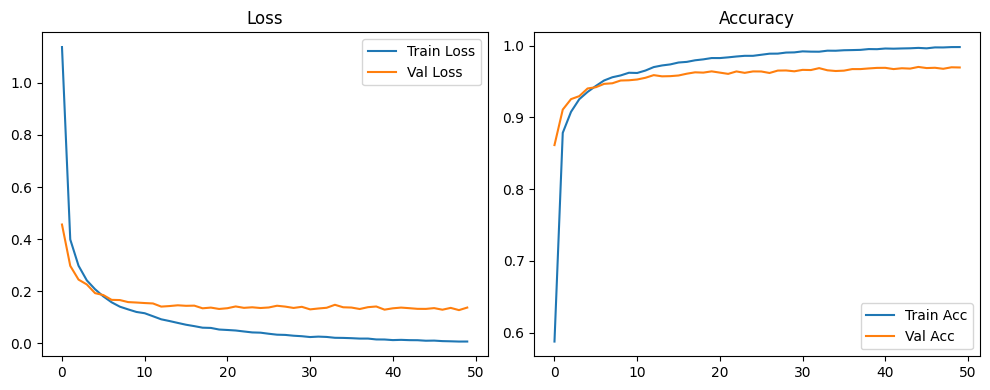

Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Original Model Final Test Loss: 0.1169 Accuracy: 0.9727


🚀 Running: batch64_lr_max_0.001_min_1e-05_dp0.05


| LR: 0.000011 | Train Acc: 0.9953 | Val Acc: 0.9707 |: 100%|██████████| 50/50 [26:00<00:00, 31.21s/it]


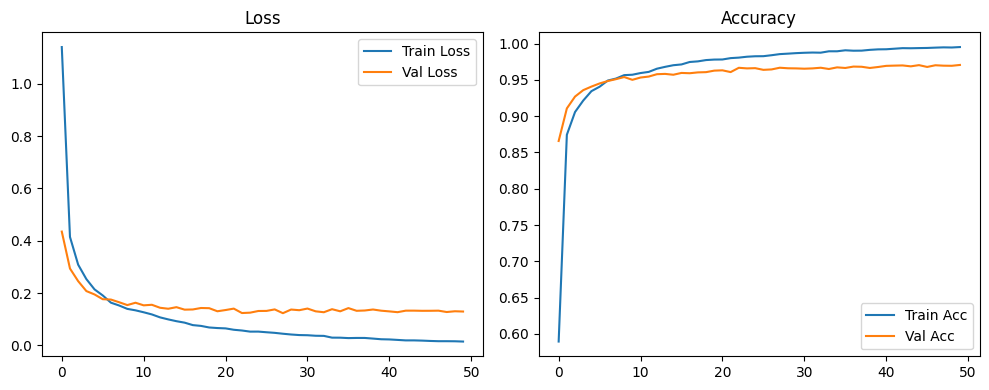

Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Original Model Final Test Loss: 0.1168 Accuracy: 0.9725


🚀 Running: batch64_lr_max_0.001_min_1e-05_dp0.1


| LR: 0.000011 | Train Acc: 0.9923 | Val Acc: 0.9698 |: 100%|██████████| 50/50 [25:50<00:00, 31.00s/it]


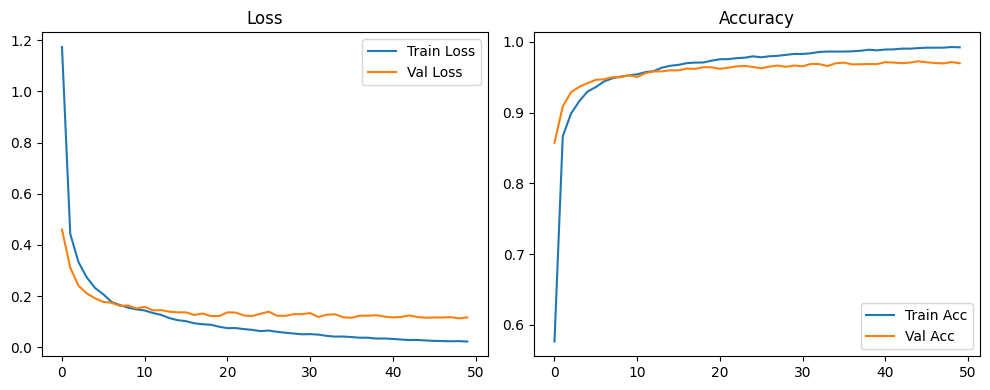

Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Original Model Final Test Loss: 0.1138 Accuracy: 0.9731


🚀 Running: batch64_lr_max_0.0005_min_1e-05_dp0.0


| LR: 0.000010 | Train Acc: 0.9963 | Val Acc: 0.9650 |: 100%|██████████| 50/50 [25:32<00:00, 30.64s/it]


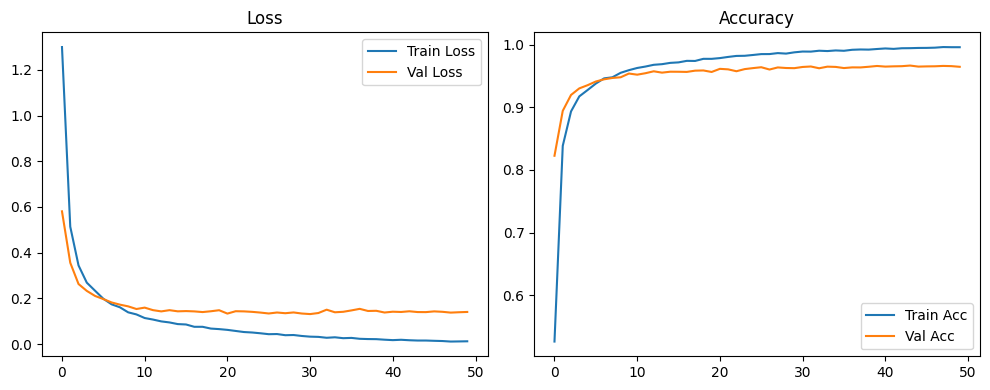

Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


Original Model Final Test Loss: 0.1239 Accuracy: 0.9683


🚀 Running: batch64_lr_max_0.0005_min_1e-05_dp0.05


| LR: 0.000010 | Train Acc: 0.9932 | Val Acc: 0.9681 |: 100%|██████████| 50/50 [26:02<00:00, 31.24s/it]


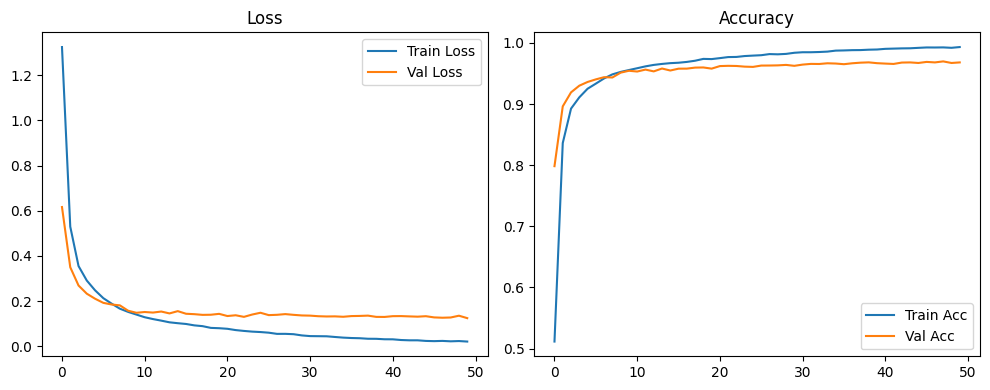

Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


Original Model Final Test Loss: 0.1155 Accuracy: 0.9703


🚀 Running: batch64_lr_max_0.0005_min_1e-05_dp0.1


| LR: 0.000010 | Train Acc: 0.9899 | Val Acc: 0.9683 |: 100%|██████████| 50/50 [25:55<00:00, 31.11s/it]


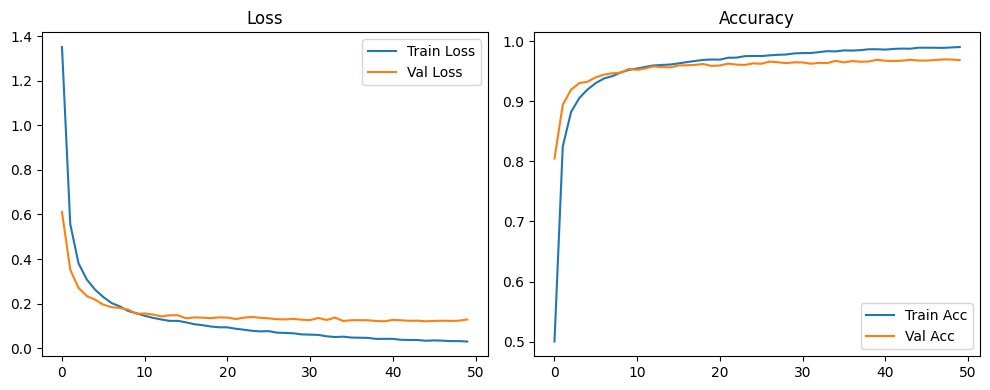

Evaluation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

Original Model Final Test Loss: 0.1129 Accuracy: 0.9730


🏆 Best Config: batch64_lr_max_0.001_min_1e-05_dp0.1 Accuracy: 0.9731


In [18]:
Hyperparameter_searching(epochs, batch_sizes, lr_max_pool, lr_min_pool, dropout_rates)